In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


# import selection classes from Feature-engine

from feature_engine.selection import (
    DropDuplicateFeatures,
    DropConstantFeatures,
    DropDuplicateFeatures,
    DropCorrelatedFeatures,
    SmartCorrelatedSelection,
    SelectByShuffling,
    SelectBySingleFeaturePerformance,
    RecursiveFeatureElimination,
)

In [2]:
# load the Santander customer satisfaction dataset

data = pd.read_csv('C:\\Users\\devanshu.tayal\\Downloads\\santander-customer-satisfaction\\train.csv')

In [3]:
data.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [4]:
# separate dataset into train and test sets

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['ID','TARGET'], axis=1),
    data['TARGET'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((53214, 369), (22806, 369))

In [5]:
# check if there missing data (this datasets do not show NAs
# as we will see in the empty list output)

[x for x in X_train.columns if X_train[x].isnull().sum() > 0]

[]

## Remove constant features

Constant features are those which contain only 1 value for all the observations.

[DropConstantFeatures](https://feature-engine.readthedocs.io/en/latest/selection/DropConstantFeatures.html)

In [6]:
# with tol=1 we tell the transformer to remove constant features
constant = DropConstantFeatures(tol=1)

# finds the constant features on the train set
constant.fit(X_train)

DropConstantFeatures()

In [7]:
# the constant features can be found in the attribute
# features_to_drop_

len(constant.features_to_drop_)

38

In [8]:
# show the names of the first 3 constant features

constant.features_to_drop_[0:3]

['ind_var2_0', 'ind_var2', 'ind_var27_0']

In [9]:
# check that the feature is indeed constant (that is,
# it has only 1 value in all the observations)

X_train['ind_var2_0'].unique()

array([0], dtype=int64)

In [10]:
# remove constant features - transform method

print('Number of variables before removing constant: ', X_train.shape[1])

X_train = constant.transform(X_train)
X_test = constant.transform(X_test)

print('Number of variables after removing constant: ', X_train.shape[1])

Number of variables before removing constant:  369
Number of variables after removing constant:  331


## Remove Quasi-constant features

Quasi-constant features are those that show the same value in most of the observations in the dataset.

In [11]:
# with tol=0.998 we tell the transformer that we want to remove
# all features that show the same value in more than 99.8% of the
# observations in the dataset

quasi_constant = DropConstantFeatures(tol=0.998)

# find quasi-constant features in the train set
quasi_constant.fit(X_train)

DropConstantFeatures(tol=0.998)

In [12]:
# the constant features can be found in the attribute
# features_to_drop_

len(constant.features_to_drop_)

38

In [13]:
# show the names of the first 3 constant features

quasi_constant.features_to_drop_[0:3]

['imp_op_var40_efect_ult1', 'imp_op_var40_efect_ult3', 'imp_sal_var16_ult1']

In [14]:
# we can evaluate the percentage of observations that show
# each value

X_train['imp_op_var40_efect_ult1'].value_counts() / len(X_train)

imp_op_var40_efect_ult1
0.0       0.999493
900.0     0.000094
1800.0    0.000056
60.0      0.000056
270.0     0.000038
600.0     0.000038
120.0     0.000038
87.9      0.000019
1710.0    0.000019
150.0     0.000019
750.0     0.000019
6600.0    0.000019
930.0     0.000019
300.0     0.000019
210.0     0.000019
870.0     0.000019
1200.0    0.000019
Name: count, dtype: float64

We can see that most of the observations show the value 0.0. Very few take a different value.

In [15]:
# remove quasi-constant features - transform method

print('Number of variables before removing quasi-constant: ', X_train.shape[1])

X_train = quasi_constant.transform(X_train)
X_test = quasi_constant.transform(X_test)

print('Number of variables after removing quasi-constant: ', X_train.shape[1])

Number of variables before removing quasi-constant:  331
Number of variables after removing quasi-constant:  192


## Remove duplicated features

That is, features that are identical

[DropDuplicateFeatures](https://feature-engine.readthedocs.io/en/latest/selection/DropDuplicateFeatures.html)

In [16]:
duplicates = DropDuplicateFeatures()

# find duplicated features in the train set
duplicates.fit(X_train)

DropDuplicateFeatures()

In [17]:
# the groups or identical variables can be seen in the 
# attribute duplicated_feature_sets

duplicates.duplicated_feature_sets_

[{'ind_var26', 'ind_var26_0'},
 {'ind_var25', 'ind_var25_0'},
 {'ind_var37', 'ind_var37_0'},
 {'ind_var39', 'ind_var40'},
 {'num_var26', 'num_var26_0'},
 {'num_var25', 'num_var25_0'},
 {'num_var37', 'num_var37_0'},
 {'num_var39', 'num_var40'}]

In [18]:
# we can go ahead and check that these variables are indeed identical
# take for example the first pair in the above cell

X_train['ind_var26'].equals(X_train['ind_var26_0'])

True

In [19]:
# inspect the values of some observations

X_train[['ind_var26','ind_var26_0']].head()

,ind_var26,ind_var26_0
7526,0,0
51929,0,0
46677,0,0
46194,0,0
20190,0,0


In [20]:
# in the attribute features_to_drop_ we find the variables
# from the groups of duplicates that will be dropped

# the transformer only leaves 1 variable per group and removes
# the rest.

duplicates.features_to_drop_

{'ind_var25',
 'ind_var26',
 'ind_var37',
 'ind_var39',
 'num_var25',
 'num_var26',
 'num_var37',
 'num_var39'}

In [21]:
# remove duplicates - transform method

print('Number of variables before removing duplicates: ', X_train.shape[1])

X_train = duplicates.transform(X_train)
X_test = duplicates.transform(X_test)

print('Number of variables after removing duplicates: ', X_train.shape[1])

Number of variables before removing duplicates:  192
Number of variables after removing duplicates:  184


## Drop Correlated features

Brute force approach. We will use a class that removes the correlated features in a first come first served basis.

[DropCorrelatedFeatures](https://feature-engine.readthedocs.io/en/latest/selection/DropCorrelatedFeatures.html)

In [22]:
# if variables is set to None, the transformer will examine all variables
# we can choose the correlation method to use (pearson, spearman or kendal)
# and the correlation threshold

correlated = DropCorrelatedFeatures(variables=None, method='pearson', threshold=0.8)

# find correlated variables in the train set
correlated.fit(X_train)

DropCorrelatedFeatures()

In [23]:
# in the attribute correlated_feature_sets_ we find the 
# variables that are correlated with each other

# note that several variables can be correlated with each other

correlated.correlated_feature_sets_

[{'delta_imp_aport_var13_1y3', 'delta_num_aport_var13_1y3'},
 {'imp_op_var39_comer_ult1',
  'imp_op_var39_comer_ult3',
  'imp_op_var41_comer_ult1',
  'imp_op_var41_comer_ult3'},
 {'imp_op_var39_efect_ult1',
  'imp_op_var39_efect_ult3',
  'imp_op_var39_ult1',
  'imp_op_var41_efect_ult1',
  'imp_op_var41_efect_ult3',
  'imp_op_var41_ult1'},
 {'imp_op_var40_comer_ult1', 'imp_op_var40_comer_ult3'},
 {'imp_op_var40_ult1', 'saldo_var40'},
 {'ind_var1', 'ind_var40', 'num_var1', 'num_var40'},
 {'ind_var10_ult1',
  'ind_var10cte_ult1',
  'ind_var37_0',
  'ind_var37_cte',
  'ind_var9_cte_ult1',
  'ind_var9_ult1'},
 {'ind_var12',
  'ind_var12_0',
  'ind_var24',
  'ind_var24_0',
  'num_meses_var12_ult3',
  'num_var12',
  'num_var12_0',
  'num_var24',
  'num_var24_0'},
 {'ind_var13',
  'ind_var13_0',
  'ind_var13_corto',
  'ind_var13_corto_0',
  'num_meses_var13_corto_ult3',
  'num_var13',
  'num_var13_0',
  'num_var13_corto',
  'num_var13_corto_0'},
 {'ind_var13_largo',
  'ind_var13_largo_0',
  'n

<Axes: >

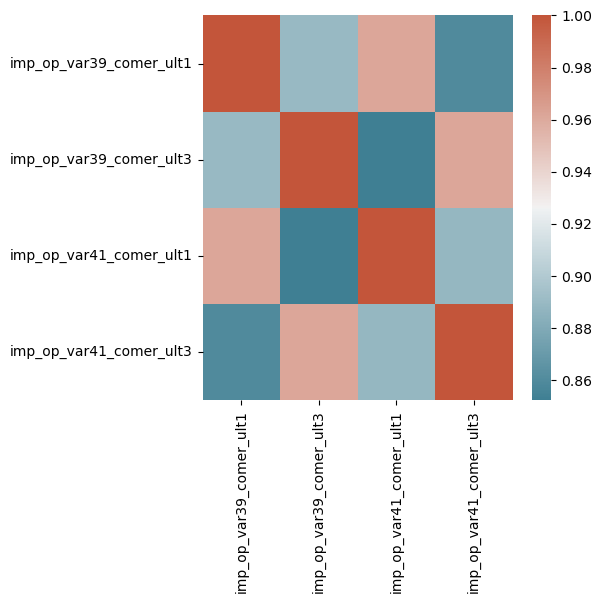

In [24]:
# let's plot a correlation heat map for the following group:
# (the first one in the sets above)

corrmat = X_train[[
    'imp_op_var39_comer_ult1',
    'imp_op_var39_comer_ult3',
    'imp_op_var41_comer_ult1',
    'imp_op_var41_comer_ult3']].corr(method='pearson')

# we can make a heatmap with the package seaborn
# and customise the colours of searborn's heatmap
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# some more parameters for the figure
fig, ax = plt.subplots()
fig.set_size_inches(5,5)

# and now plot the correlation matrix
sns.heatmap(corrmat, cmap=cmap)

We can see that indeed all those variables show a correlation coefficient higher than 0.8 with each other.

In [25]:
# in the features_to_drop_ the transformer stores all the
# variables that will be dropped. 

# the transformer selects 1 variable per group of correlated ones
# and drops the rest on a first come, first serve basis

len(correlated.features_to_drop_)

105

In [26]:
# remove correlated variables

print('Number of variables before removing correlated: ', X_train.shape[1])

X_train = correlated.transform(X_train)
X_test = correlated.transform(X_test)

print('Number of variables after removing correlated: ', X_train.shape[1])

Number of variables before removing correlated:  184
Number of variables after removing correlated:  79


## Drop Correlated Features Smartly

With this class, each feature in the correlated group is selected based on different characteristics:

- the number of missing values
- the variance
- the cardinality
- the importance derived from a machine learning model

The transformer will select the feature with less missing values, or highest variance, cardinality or performance, depending what we choose on the selection_method parameter.

[SmartCorrelatedSelection](https://feature-engine.readthedocs.io/en/latest/selection/SmartCorrelatedSelection.html)

In [27]:
smart_corr = SmartCorrelatedSelection(
    variables=None, # examines all variables
    method="pearson", # the correlation method
    threshold=0.7, # the correlation coefficient threshold
    missing_values="ignore",
    selection_method="model_performance", # how to select the features
    estimator=RandomForestClassifier(n_estimators=10, random_state=1), # the model from which to derive the importance
)

# find correlated features and select the best from each group

# the method builds a random forest using each single feature from the correlated feature group
# and retains the feature from the group with the best performance

smart_corr.fit(X_train, y_train)

SmartCorrelatedSelection(estimator=RandomForestClassifier(n_estimators=10,
                                                          random_state=1),
                         selection_method='model_performance', threshold=0.7)

In [28]:
# the correlated feature groups

smart_corr.correlated_feature_sets_

[{'delta_imp_aport_var13_1y3', 'imp_aport_var13_ult1', 'num_aport_var13_ult1'},
 {'imp_aport_var13_hace3', 'num_aport_var13_hace3'},
 {'imp_op_var39_comer_ult1', 'num_op_var39_comer_ult1'},
 {'imp_trans_var37_ult1', 'imp_var43_emit_ult1'},
 {'ind_var13', 'num_var30_0', 'saldo_var13'},
 {'ind_var13_largo', 'saldo_var13_largo'},
 {'ind_var1_0', 'var21'},
 {'ind_var5_0', 'num_meses_var8_ult3'},
 {'num_med_var22_ult3', 'num_var22_hace2'},
 {'num_med_var45_ult3', 'num_var45_hace3'},
 {'num_op_var40_comer_ult1', 'num_op_var40_ult1'}]

In [29]:
# lets examine the performace of a random forest based on
# each feature from the fifth group from above, to understand
# what the transformer is doing

# select fifth group of correlated features
group = smart_corr.correlated_feature_sets_[4]

# build random forest with cross validation for
# each feature

for f in group:
    
    model = cross_validate(
        RandomForestClassifier(n_estimators=10, random_state=1),
        X_train[f].to_frame(),
        y_train,
        cv=3,
        return_estimator=False,
        scoring='roc_auc',
    )

    print(f, model["test_score"].mean())

num_var30_0 0.5346497482186976
saldo_var13 0.5196633518077584
ind_var13 0.521803212621799


The variable **num_var30_0** returns the highest performing random forest, therefore this one will be retained and the other ones removed.

In [30]:
# this variable, which shows the best performance will be retained
# and thus is not in the features_to_drop_ attribute

'num_var30_0' in smart_corr.features_to_drop_

False

In [31]:
# this variable will be dropped, and thus it is in the features_to_drop_ attribute

'ind_var12_0' in smart_corr.features_to_drop_

False

In [32]:
# this variable will be dropped, and thus it is in the features_to_drop_ attribute

'ind_var24_0' in smart_corr.features_to_drop_

False

In [33]:
# remove correlated variables

print('Number of variables before removing correlated: ', X_train.shape[1])

X_train = smart_corr.transform(X_train)
X_test = smart_corr.transform(X_test)

print('Number of variables after removing correlated: ', X_train.shape[1])

Number of variables before removing correlated:  79
Number of variables after removing correlated:  66


## Select features in a pipeline

We can perform all feature selection procedures in 1 step using a Pipeline from Scikit-learn.

In [34]:
# load data again
data = pd.read_csv('C:\\Users\\devanshu.tayal\\Downloads\\santander-customer-satisfaction\\train.csv')

# separate dataset into train and test sets

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['ID','TARGET'], axis=1),
    data['TARGET'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((53214, 369), (22806, 369))

In [35]:
pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=0.998)), # drops constand and quasi-constant altogether
    ('duplicated', DropDuplicateFeatures()), # drops duplicates
    ('correlation', SmartCorrelatedSelection( # drops correlated
        threshold=0.8,
        selection_method="model_performance",
        estimator=RandomForestClassifier(n_estimators=10, random_state=1),
    )),
])

# find features to remove

pipe.fit(X_train, y_train)

Pipeline(steps=[('constant', DropConstantFeatures(tol=0.998)),
                ('duplicated', DropDuplicateFeatures()),
                ('correlation',
                 SmartCorrelatedSelection(estimator=RandomForestClassifier(n_estimators=10,
                                                                           random_state=1),
                                          selection_method='model_performance'))])

In [36]:
# remove variables

print('Number of original variables: ', X_train.shape[1])

X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)

print('Number of variables after selection: ', X_train.shape[1])

Number of original variables:  369
Number of variables after selection:  79


We can appreciate how in 1 cells we chopped down the number of features from 369 to 81.

## Select features by Shuffling

This class, builds a model with all features, then shuffles each feature, one at a time, and determines a drop in model performance. If the feature is important, we should see a big drop. Otherwise, the drop will be small, and we could remove the feature.

[SelectByShuffling](https://feature-engine.readthedocs.io/en/latest/selection/SelectByShuffling.html)

In [37]:
# load data again
data = pd.read_csv('C:\\Users\\devanshu.tayal\\Downloads\\santander-customer-satisfaction\\train.csv')

# separate dataset into train and test sets

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['ID','TARGET'], axis=1),
    data['TARGET'],
    test_size=0.3,
    random_state=0)

In [38]:
# let's remove constant, quasi-constant and duplicates to speed things up

pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=0.998)), # drops constand and quasi-constant altogether
    ('duplicated', DropDuplicateFeatures()),
])

# find features to remove
pipe.fit(X_train, y_train)

# remove variables

X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)

In [39]:
shuffle = SelectByShuffling(
    estimator = RandomForestClassifier(n_estimators=10, max_depth=2, random_state=1), # the model
    scoring="roc_auc", # the metric to determine model performance
    cv=3, # the cross-validation fold
)

shuffle.fit(X_train, y_train)

SelectByShuffling(estimator=RandomForestClassifier(max_depth=2, n_estimators=10,
                                                   random_state=1))

In [40]:
# this is the performace of the model (roc-auc) using all the features

shuffle.initial_model_performance_

0.7675761929904802

In [41]:
# in the attribute performance_drifts_ we can find the 
# performance drift caused by shuffling each feature

shuffle.performance_drifts_

{'var3': 3.077202469814466e-05,
 'var15': 0.05504067063956475,
 'imp_ent_var16_ult1': 0.0,
 'imp_op_var39_comer_ult1': 0.0,
 'imp_op_var39_comer_ult3': 0.0,
 'imp_op_var40_comer_ult1': 0.0,
 'imp_op_var40_comer_ult3': 0.0,
 'imp_op_var40_ult1': 0.0,
 'imp_op_var41_comer_ult1': 0.0,
 'imp_op_var41_comer_ult3': -0.000280549502042593,
 'imp_op_var41_efect_ult1': 0.00035061331055408207,
 'imp_op_var41_efect_ult3': 0.002404323665648578,
 'imp_op_var41_ult1': -2.2532520817519774e-05,
 'imp_op_var39_efect_ult1': 0.0,
 'imp_op_var39_efect_ult3': 0.0021558353623811755,
 'imp_op_var39_ult1': 0.0,
 'ind_var1_0': 0.0,
 'ind_var1': 0.0,
 'ind_var5_0': 0.0,
 'ind_var5': 0.019456761661980737,
 'ind_var8_0': 0.0,
 'ind_var8': 0.0,
 'ind_var12_0': 0.0,
 'ind_var12': 0.0,
 'ind_var13_0': 0.0,
 'ind_var13_corto_0': 0.0,
 'ind_var13_corto': 0.0,
 'ind_var13_largo_0': 0.0,
 'ind_var13_largo': 0.0,
 'ind_var13': 0.0,
 'ind_var14_0': 0.0,
 'ind_var14': 0.0,
 'ind_var19': 0.0,
 'ind_var20_0': 0.0,
 'ind_var20

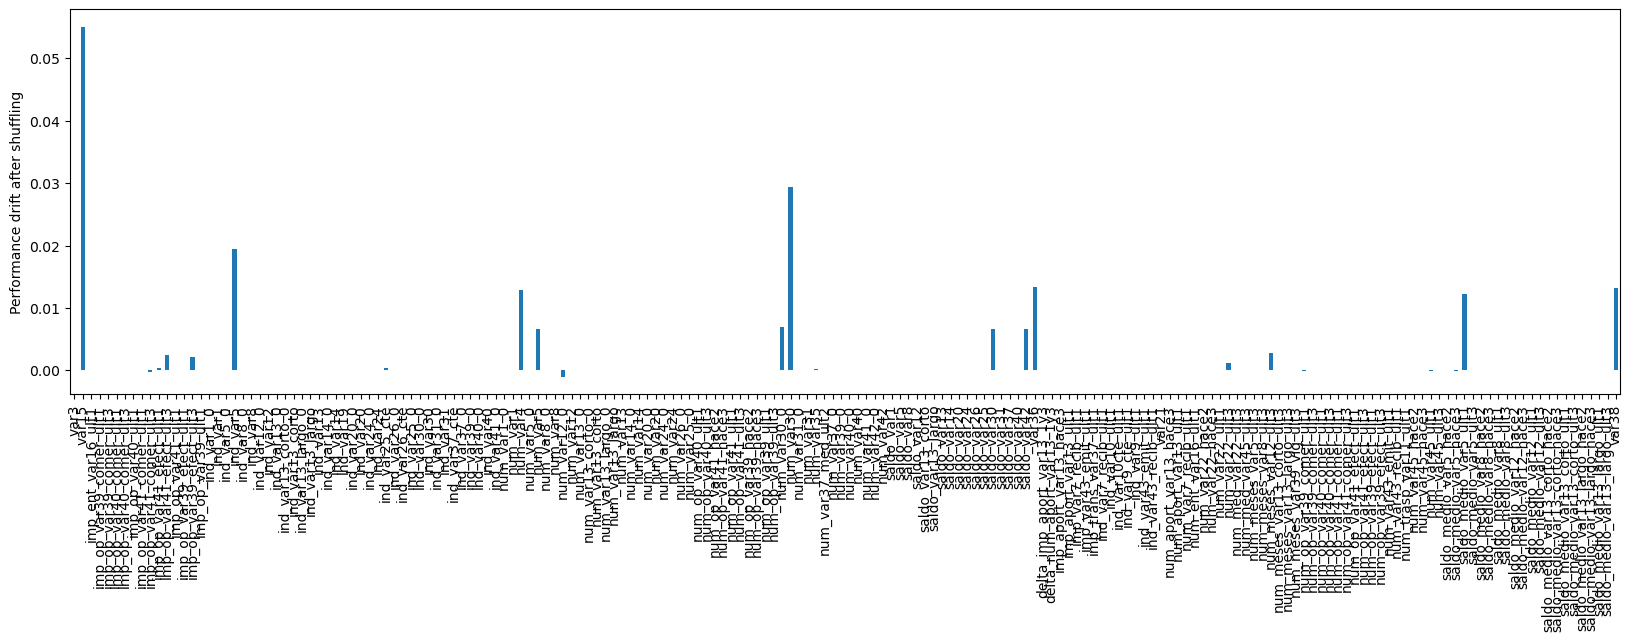

In [42]:
pd.Series(shuffle.performance_drifts_).plot.bar(figsize=(20,5))
plt.ylabel('Performance drift after shuffling')
plt.show()

In [43]:
# here we find the attributes that will be dropped

len(shuffle.features_to_drop_)

169

In [44]:
# remove variables

print('Number of variables before removing non important: ', X_train.shape[1])

X_train = shuffle.transform(X_train)
X_test = shuffle.transform(X_test)

print('Number of variables after removing non important: ', X_train.shape[1])

Number of variables before removing non important:  184
Number of variables after removing non important:  15


In [45]:
# we can go ahead and train a random forest using the selected features and evaluate
# its performance

rf = RandomForestClassifier(n_estimators=10, max_depth=3, random_state=1)

rf.fit(X_train, y_train)

pred = rf.predict_proba(X_train)
print('Train roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))

pred = rf.predict_proba(X_test)
print('Test roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

Train roc-auc: 0.7946600821633611
Test roc-auc: 0.7952781978049392


We see that the model with few features shows better performance than the model with all the features. And, it is much simpler and easier to interpret for those who will actually use the model.

## Select features by univariate model performance

This selection procedure builds 1 model per feature, and selects those features that return models with a performance above a certain threshold.

[SelectBySingleFeaturePerformance](https://feature-engine.readthedocs.io/en/latest/selection/SelectBySingleFeaturePerformance.html)

In [46]:
# load data again
data = pd.read_csv('C:\\Users\\devanshu.tayal\\Downloads\\santander-customer-satisfaction\\train.csv')

# separate dataset into train and test sets

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['ID','TARGET'], axis=1),
    data['TARGET'],
    test_size=0.3,
    random_state=0)

# let's remove constant, quasi-constant and duplicates to speed things up

pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=0.998)), # drops constand and quasi-constant altogether
    ('duplicated', DropDuplicateFeatures()),
])

# find features to remove
pipe.fit(X_train, y_train)

# remove variables

X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)

In [47]:
sel = SelectBySingleFeaturePerformance(
    estimator = RandomForestClassifier(n_estimators=10, max_depth=2, random_state=1), # the model
    scoring="roc_auc", # the metric to determine model performance
    cv=3, # the cross-validation fold,
    threshold=None, # the performance threshold
)

sel.fit(X_train, y_train)

SelectBySingleFeaturePerformance(estimator=RandomForestClassifier(max_depth=2,
                                                                  n_estimators=10,
                                                                  random_state=1))

In [48]:
# the univariate performance of the features

sel.feature_performance_

{'var3': 0.5029632787171933,
 'var15': 0.7046767732309168,
 'imp_ent_var16_ult1': 0.5006955094143339,
 'imp_op_var39_comer_ult1': 0.5075504823753088,
 'imp_op_var39_comer_ult3': 0.5109389082825512,
 'imp_op_var40_comer_ult1': 0.5001164460497465,
 'imp_op_var40_comer_ult3': 0.5000491427552901,
 'imp_op_var40_ult1': 0.5007062151642744,
 'imp_op_var41_comer_ult1': 0.5072222194196698,
 'imp_op_var41_comer_ult3': 0.512288911757716,
 'imp_op_var41_efect_ult1': 0.5179918115025716,
 'imp_op_var41_efect_ult3': 0.5168066681688348,
 'imp_op_var41_ult1': 0.5236644997331971,
 'imp_op_var39_efect_ult1': 0.5179100750635618,
 'imp_op_var39_efect_ult3': 0.5167694782992768,
 'imp_op_var39_ult1': 0.5228100155373502,
 'ind_var1_0': 0.5012573651075508,
 'ind_var1': 0.5020403141549071,
 'ind_var5_0': 0.5179815121227204,
 'ind_var5': 0.6644335369107354,
 'ind_var8_0': 0.522325944684343,
 'ind_var8': 0.5108950623511844,
 'ind_var12_0': 0.5231394976032572,
 'ind_var12': 0.5175438655492329,
 'ind_var13_0': 0.52

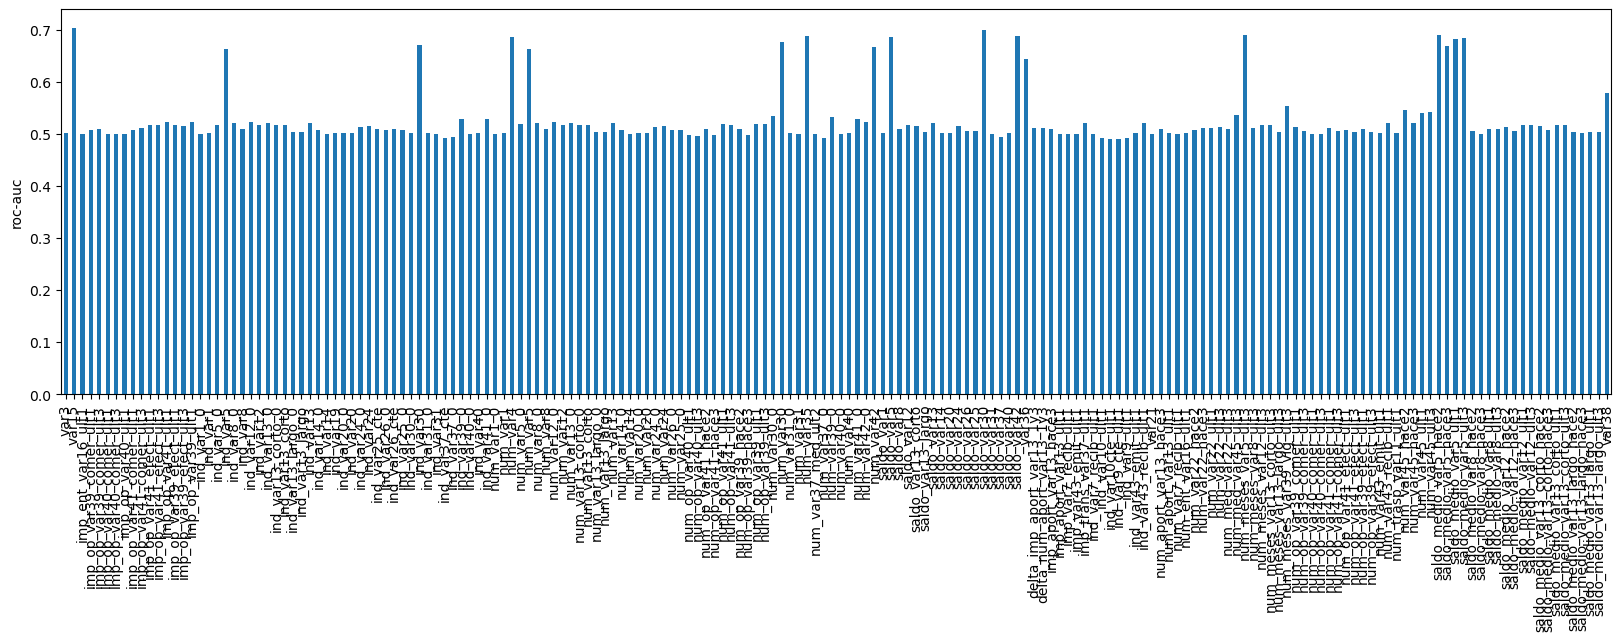

In [49]:
pd.Series(sel.feature_performance_).plot.bar(figsize=(20,5))
plt.ylabel('roc-auc')
plt.show()

In [50]:
# the features that will be dropped

len(sel.features_to_drop_)

156

In [51]:
# when we leave the threshold to None, the selector selects features which
# performance is bigger than the mean performance of all features

sel.threshold

In [52]:
# remove variables

print('Number of variables before removing non important: ', X_train.shape[1])

X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

print('Number of variables after removing non important: ', X_train.shape[1])

Number of variables before removing non important:  184
Number of variables after removing non important:  28


## Select Features Recursively

- This method starts by building a model with all features
- Then it ranks features by importance, derived from the model, from most to least important
- Then removes least important features
- Trains a new model and determines performance
- If performance drop is big, then retains the feature, otherwise it removes it
- Repeats steps 3-5 untill all features have been examined.

[RecursiveFeatureElimination](https://feature-engine.readthedocs.io/en/latest/selection/RecursiveFeatureElimination.html)

In [53]:
# load data again
data = pd.read_csv('C:\\Users\\devanshu.tayal\\Downloads\\santander-customer-satisfaction\\train.csv')

# separate dataset into train and test sets

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['ID','TARGET'], axis=1),
    data['TARGET'],
    test_size=0.3,
    random_state=0)

# let's remove constant, quasi-constant and duplicates to speed things up

pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=0.998)), # drops constand and quasi-constant altogether
    ('duplicated', DropDuplicateFeatures()),
])

# find features to remove
pipe.fit(X_train, y_train)

# remove variables

X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)

In [54]:
rfe = RecursiveFeatureElimination(
    estimator = RandomForestClassifier(n_estimators=10, max_depth=2, random_state=1), # the model
    scoring="roc_auc", # the metric to determine model performance
    cv=3, # the cross-validation fold
    threshold = 0.04, 
)

rfe.fit(X_train, y_train)

RecursiveFeatureElimination(estimator=RandomForestClassifier(max_depth=2,
                                                             n_estimators=10,
                                                             random_state=1),
                            threshold=0.04)

In [55]:
# the feature importance derived from the first model, trained
# using all the features

rfe.feature_importances_

num_var39_0          0.000000
saldo_var5           0.000000
saldo_var8           0.000000
saldo_var12          0.000000
saldo_var13_corto    0.000000
                       ...   
num_var5             0.079403
num_var4             0.091691
var36                0.118260
ind_var5             0.143499
num_var30            0.146509
Length: 184, dtype: float64

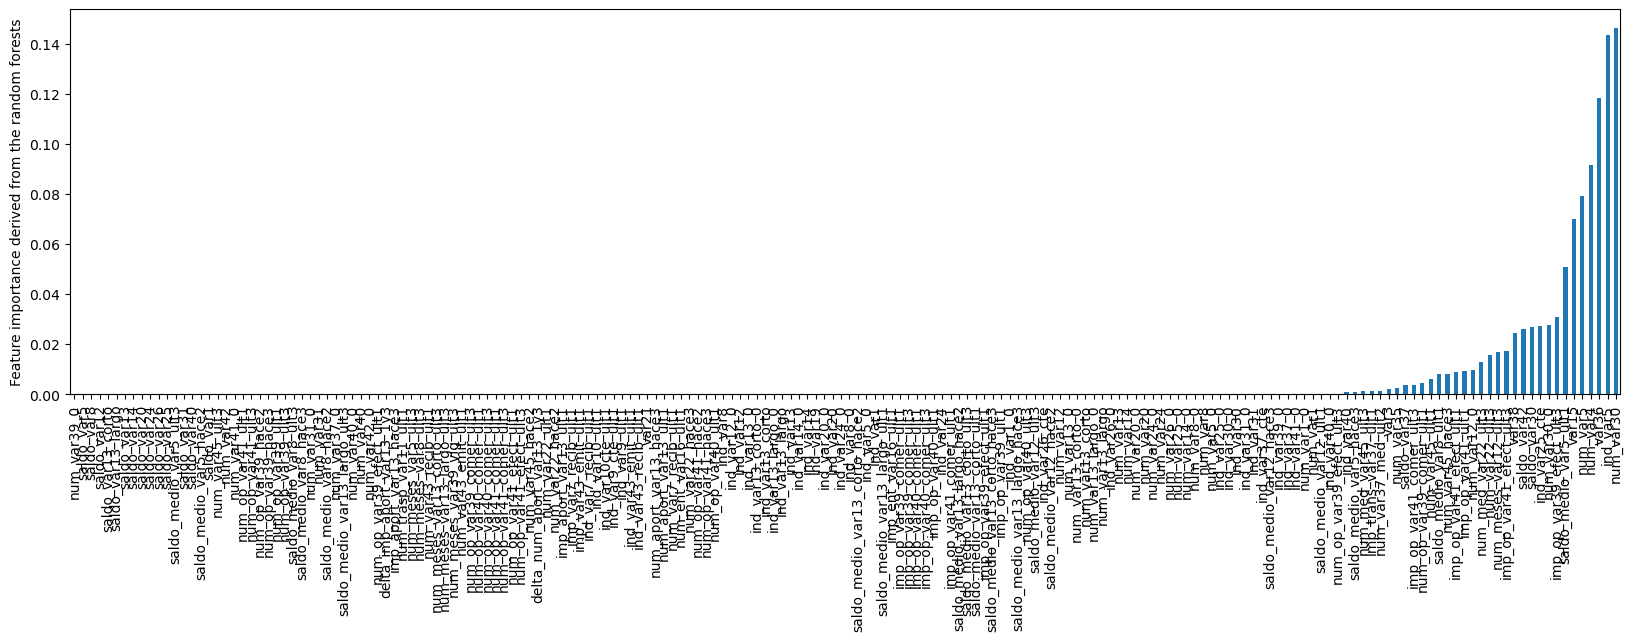

In [56]:
# plot of feature importance, derived from the Random Forests
pd.Series(rfe.feature_importances_).plot.bar(figsize=(20,5))
plt.ylabel('Feature importance derived from the random forests')
plt.show()

The model begins by removing features, 1 by 1, from those on the left, to those on the right.

In [57]:
# the performance of the random forest trained on all features

rfe.initial_model_performance_

0.7675761929904802

In [58]:
# the drop in performance caused when removing each feature

rfe.performance_drifts_

{'num_var39_0': -0.0022983311361324255,
 'saldo_var5': 0.052403174619189086,
 'saldo_var8': 0.05355174464488299,
 'saldo_var12': 0.05355174464488299,
 'saldo_var13_corto': 0.05355174464488299,
 'saldo_var13_largo': 0.05355174464488299,
 'saldo_var13': 0.0537197156194088,
 'saldo_var14': 0.0537197156194088,
 'saldo_var20': 0.0537197156194088,
 'saldo_var24': 0.03767350601539843,
 'saldo_var26': -0.034401428068570605,
 'saldo_var25': -0.008948661725206475,
 'saldo_medio_var5_ult3': 0.010073648272955094,
 'saldo_var31': 0.03910136439458156,
 'saldo_var40': -0.03324164783351491,
 'saldo_medio_var5_hace2': 0.030502881584316355,
 'saldo_var1': -0.044342641730677035,
 'num_var45_ult3': 0.03302274047020115,
 'num_var42': -0.01746734185757648,
 'num_var41_0': 0.0021444429871171344,
 'num_op_var41_ult1': -0.011778524938231616,
 'num_op_var41_ult3': 0.015511650770589691,
 'num_op_var39_hace2': 0.002816130706557174,
 'num_op_var39_hace3': -0.02225965030872923,
 'num_op_var39_ult1': 0.0591480072731

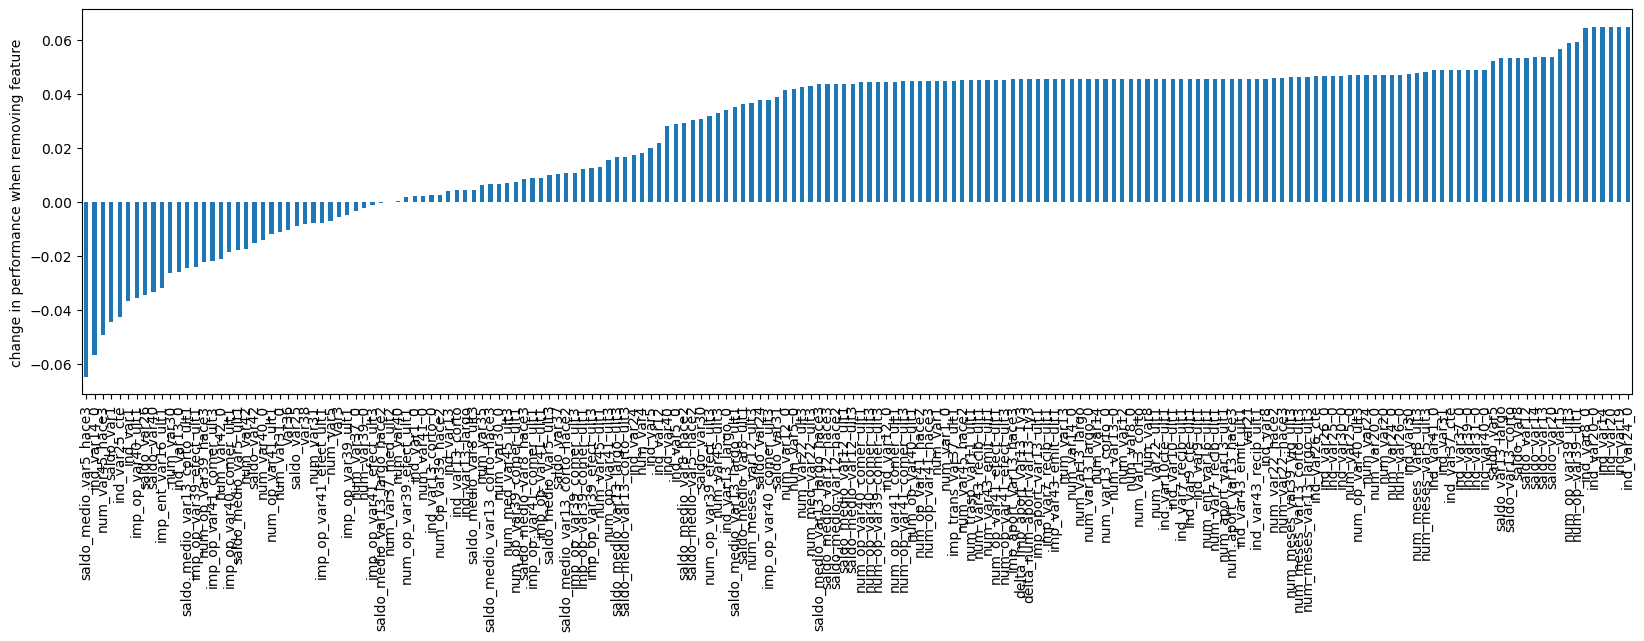

In [59]:
# same as above in a plot

pd.Series(rfe.performance_drifts_).sort_values().plot.bar(figsize=(20,5))
plt.ylabel('change in performance when removing feature')
plt.show()

In [60]:
# the number of features that will be dropped
len(rfe.features_to_drop_)

83

In [61]:
# remove variables

print('Number of variables before removing non important: ', X_train.shape[1])

X_train = rfe.transform(X_train)
X_test = rfe.transform(X_test)

print('Number of variables after removing non important: ', X_train.shape[1])

Number of variables before removing non important:  184
Number of variables after removing non important:  101


## Feature Selection and Machine Learning Pipeline

Now we will select features and train a machine learning model altogether in 1 pipeline.

In [62]:
# load data again
data = pd.read_csv('C:\\Users\\devanshu.tayal\\Downloads\\santander-customer-satisfaction\\train.csv')

# separate dataset into train and test sets

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['ID','TARGET'], axis=1),
    data['TARGET'],
    test_size=0.3,
    random_state=0)

In [63]:
pipe = Pipeline([
    # ======== FEATURE SELECTION =======
    ('constant', DropConstantFeatures(tol=0.998)), # drops constand and quasi-constant altogether
    ('duplicated', DropDuplicateFeatures()), # drop duplicated
    ('shuffle', SelectByShuffling( # select by feature shuffling
        estimator = RandomForestClassifier(n_estimators=10, max_depth=2, random_state=1), # the model
        scoring="roc_auc", # the metric to determine model performance
        cv=3, # the cross-validation fold
    )),
    
    # =====  the machine learning model ====
    ('random_forest', RandomForestClassifier(n_estimators=10, max_depth=2, random_state=1)),
])

# find features to remove
pipe.fit(X_train, y_train)

Pipeline(steps=[('constant', DropConstantFeatures(tol=0.998)),
                ('duplicated', DropDuplicateFeatures()),
                ('shuffle',
                 SelectByShuffling(estimator=RandomForestClassifier(max_depth=2,
                                                                    n_estimators=10,
                                                                    random_state=1))),
                ('random_forest',
                 RandomForestClassifier(max_depth=2, n_estimators=10,
                                        random_state=1))])

In [64]:
# the pipeline takes in the raw data, removes all unwanted features and then
# makes the prediction with the model trained on the final subset of variables

# obtain predictions and determine model performance

pred = pipe.predict_proba(X_train)
print('Train roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))

pred = pipe.predict_proba(X_test)
print('Test roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

Train roc-auc: 0.7782035975803885
Test roc-auc: 0.7725900091997276
